In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm, feature_selection, linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
import missingno as msno

##Loading in data file
csv_data = "Manhattan12.csv"
df = pd.read_csv(csv_data, header = 4)

In [135]:
##Show the shape of the dataset
print(df.shape)

(27395, 21)


In [136]:
##Rename incorrectly formatted column names 
def remove_newlines(df):
    old_columns = df.columns
    cleaned_columns = [col.replace("\n", " ") for col in old_columns]
    #Renaming DF columns
    df.rename(dict(zip(old_columns, cleaned_columns)), axis = 1, inplace = True)
    return df

df = remove_newlines(df)

In [137]:
##Create list of categorical variables and numerical values 
cat_variables = list(df.select_dtypes(include=['category', 'object']))
num_variables = list(df.select_dtypes(include=['int', 'float']))
print(num_variables)

['BOROUGH', 'BLOCK', 'LOT', 'ZIP CODE', 'COMMERCIAL UNITS', 'YEAR BUILT', 'TAX CLASS AT TIME OF SALE']


In [138]:
##For each numerical column, remove the ',' the '$' for the sale price, and then convert them to numeric.
def clean_numericals(df, df_numericals_list):
    for column in df_numericals_list:
        df[column] = df[column].astype("string")
        df[column] = df[column].str.replace('$','', regex = True)
        df[column] = df[column].str.replace(",", "", regex = True)
        df[column] = pd.to_numeric(df[column])
    return df
#appending sale price and sale date to num_variables to convert it also
num_variables.append("SALE PRICE")
df = clean_numericals(df, num_variables)


In [139]:
##Convert SALE_DATE to datetime
df["SALE DATE"] = pd.to_datetime(df["SALE DATE"], format = '%d/%m/%Y')

In [140]:
## For each categorical variable, replace with NaNs. Also same with 0s
for col in df.select_dtypes(include='object'):
    df[col] = df[col].str.strip().replace('', np.nan)

#Need to convert columns to numeric for replacement
numeric_conversion_list = ["RESIDENTIAL UNITS", "TOTAL UNITS", "LAND SQUARE FEET", "GROSS SQUARE FEET"]
df = clean_numericals(df, numeric_conversion_list)
df.replace(0,np.nan, inplace=True)

    

       BOROUGH         BLOCK           LOT  EASE-MENT      ZIP CODE  \
count  27395.0  27395.000000  27395.000000        0.0  27394.000000   
mean       1.0   1109.666728    741.789086        NaN  10029.226217   
std        0.0    465.994469    819.422424        NaN     34.966983   
min        1.0      7.000000      1.000000        NaN  10001.000000   
25%        1.0    877.000000     37.000000        NaN  10016.000000   
50%        1.0   1047.000000   1007.000000        NaN  10019.000000   
75%        1.0   1411.000000   1233.000000        NaN  10027.000000   
max        1.0   2250.000000   9117.000000        NaN  10463.000000   

       RESIDENTIAL UNITS  COMMERCIAL UNITS   TOTAL UNITS  LAND SQUARE FEET  \
count       11023.000000       3433.000000  17691.000000       4489.000000   
mean            4.390003          2.992426      3.545249       5893.466028   
std            23.260831         12.689861     19.482767       7884.729624   
min             1.000000          1.000000      

<AxesSubplot:>

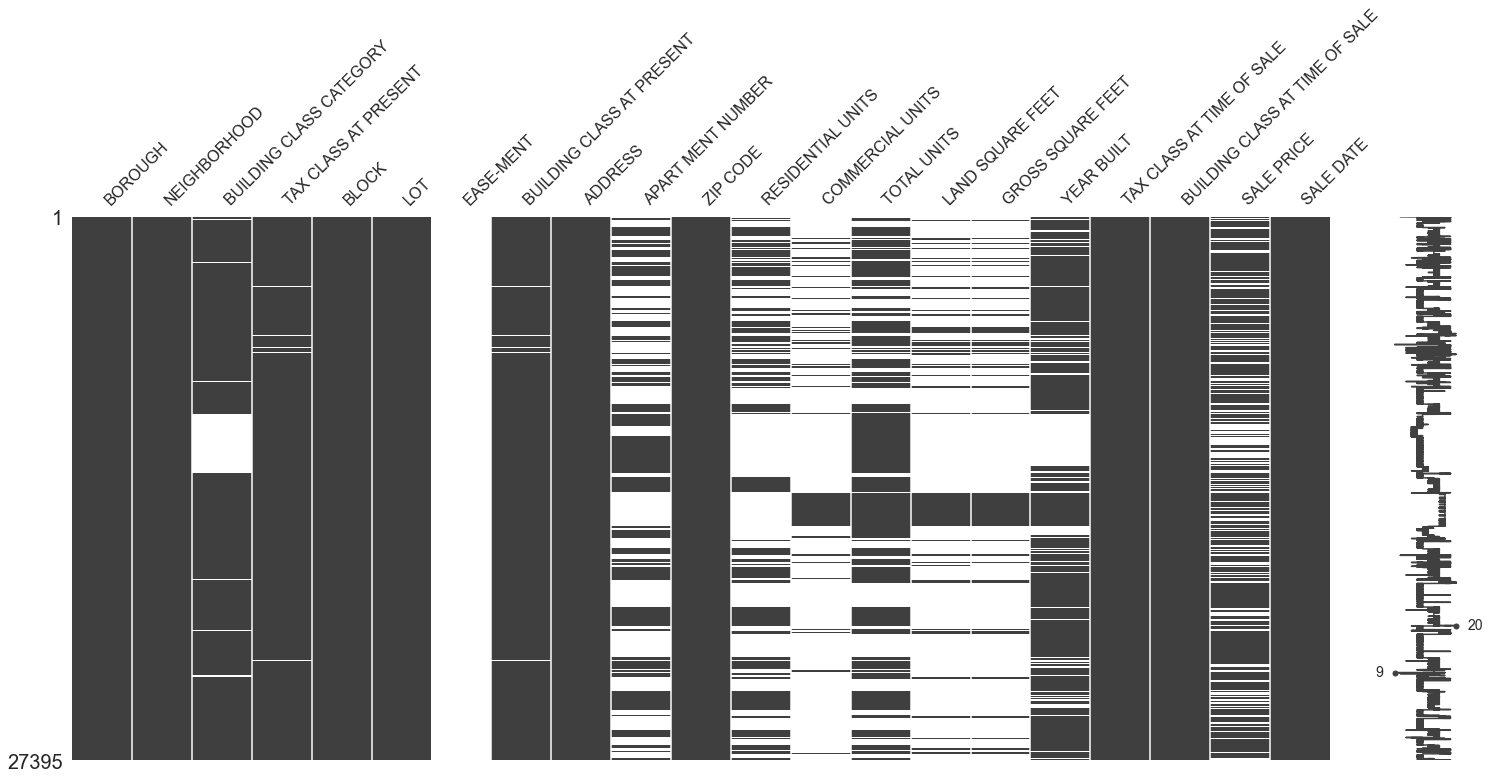

In [141]:
##Show a summary of all missing values as well as the summary statistics
print(df.describe())
#Missing values
df.isnull().sum()
msno.matrix(df)



In [142]:
def drop_columns(df, drop_columns_list):
    for column in drop_columns_list:
        df.drop([column], axis = 1, inplace = True)
    return df
    
drop_columns_list = ['BOROUGH','EASE-MENT','APART MENT NUMBER']

df = drop_columns(df, drop_columns_list)
df

,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,NaN,13 CONDOS - ELEVATOR APARTMENTS,NaN,738,1306,NaN,345 WEST 14TH STREET,10014.0,NaN,NaN,NaN,NaN,NaN,NaN,2,R4,2214693.0,2013-05-20
1,NaN,13 CONDOS - ELEVATOR APARTMENTS,NaN,738,1307,NaN,345 WEST 14TH STREET,10014.0,NaN,NaN,NaN,NaN,NaN,NaN,2,R4,1654656.0,2013-05-16
2,NaN,13 CONDOS - ELEVATOR APARTMENTS,NaN,738,1308,NaN,345 WEST 14TH STREET,10014.0,NaN,NaN,NaN,NaN,NaN,NaN,2,R4,1069162.0,2013-05-23
3,NaN,13 CONDOS - ELEVATOR APARTMENTS,NaN,738,1309,NaN,345 WEST 14TH STREET,10014.0,NaN,NaN,NaN,NaN,NaN,NaN,2,R4,1374637.0,2013-05-15
4,NaN,13 CONDOS - ELEVATOR APARTMENTS,NaN,738,1310,NaN,345 WEST 14TH STREET,10014.0,NaN,NaN,NaN,NaN,NaN,NaN,2,R4,1649565.0,2013-05-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27390,WASHINGTON HEIGHTS UPPER,31 COMMERCIAL VACANT LAND,4,2170,400,V1,44 FAIRVIEW AVENUE,10040.0,NaN,NaN,NaN,16217.0,NaN,NaN,4,V1,NaN,2013-04-29
27391,WASHINGTON HEIGHTS UPPER,31 COMMERCIAL VACANT LAND,4,2180,75,V1,BENNETT AVENUE,10033.0,NaN,NaN,NaN,4150.0,NaN,NaN,4,V1,495000.0,2013-06-26
27392,WASHINGTON HEIGHTS UPPER,31 COMMERCIAL VACANT LAND,4,2180,75,V1,BENNETT AVENUE,10033.0,NaN,NaN,NaN,4150.0,NaN,NaN,4,V1,NaN,2013-04-02
27393,WASHINGTON HEIGHTS UPPER,31 COMMERCIAL VACANT LAND,4,2180,76,V1,N/A MAGAW PLACE,10033.0,NaN,NaN,NaN,760.0,NaN,NaN,4,V1,NaN,2013-06-26


In [143]:
##Drop duplicates
df.drop_duplicates(inplace=True)

In [144]:
##Drop NAN 

In [145]:
imputed_columns = ['RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT']
imputed_df = df.copy()

for column in imputed_columns:
    imputed_df[column].fillna(imputed_df[column].median(), inplace = True)

df = df.dropna()
imputed_df["SALE PRICE"] = imputed_df["SALE PRICE"].interpolate(method='polynomial', order=1)
imputed_df = imputed_df.dropna()

df

,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
24,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,385,1,C7,17 AVENUE B,10009.0,7.0,1.0,8.0,2093.0,5852.0,1997.0,2,C7,283.0,2013-04-18
26,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,397,33,C7,14 AVENUE B,10009.0,25.0,2.0,27.0,3574.0,18212.0,1925.0,2,C7,13185684.0,2013-01-31
30,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,398,53,C7,170 EAST 2ND STREET,10009.0,36.0,3.0,39.0,4452.0,17664.0,1900.0,2,C7,3810602.0,2012-10-26
31,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,400,56,C4,203 EAST 4TH STREET,10009.0,10.0,1.0,10.0,2404.0,6975.0,1900.0,2,C4,7333333.0,2013-04-09
32,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,400,57,C4,201 EAST 4TH STREET,10009.0,9.0,1.0,9.0,2404.0,6875.0,1900.0,2,C4,7333333.0,2013-04-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27057,WASHINGTON HEIGHTS UPPER,07 RENTALS - WALKUP APARTMENTS,2,2180,13,C7,500 FT WASHINGTON AVENUE,10033.0,56.0,1.0,57.0,14150.0,44295.0,1925.0,2,C7,8620000.0,2013-03-22
27059,WASHINGTON HEIGHTS UPPER,07 RENTALS - WALKUP APARTMENTS,2,2180,120,C7,4321 BROADWAY,10033.0,69.0,5.0,74.0,12400.0,54000.0,1949.0,2,C7,11400000.0,2013-04-11
27060,WASHINGTON HEIGHTS UPPER,08 RENTALS - ELEVATOR APARTMENTS,2,2158,16,D7,440 AUDUBON AVENUE,10040.0,68.0,3.0,71.0,14231.0,66240.0,1911.0,2,D7,7810000.0,2012-08-29
27064,WASHINGTON HEIGHTS UPPER,08 RENTALS - ELEVATOR APARTMENTS,2,2175,33,D7,4720 BROADWAY,10040.0,50.0,2.0,52.0,12050.0,52378.0,1920.0,2,D7,11360000.0,2013-05-30


In [146]:
##Removing outliers
#This is Ella's code, this may be worth looking at
df = df.select_dtypes(include = ['int','float'])
imputed_df = imputed_df.select_dtypes(include = ['int','float'])

def removing_outliers (df, threshold):
    num_df = df.select_dtypes(include = ['int','float'])
    z = np.abs((num_df - num_df.mean()) / num_df.std())  ## calclulating the z score for numerical columns in the dataframe
    outliers = df[(z > threshold).any(axis=1)]  ## outliers identified in the datframe
    
    
    return df[(z <= threshold).all (axis =1)]    ## returns a df with the removal of outliers from the dataframe
df = removing_outliers (df, 3)
imputed_df = removing_outliers(imputed_df, 3)
df

,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE
26,397,33,10009.0,25.0,2.0,27.0,3574.0,18212.0,1925.0,2,13185684.0
30,398,53,10009.0,36.0,3.0,39.0,4452.0,17664.0,1900.0,2,3810602.0
31,400,56,10009.0,10.0,1.0,10.0,2404.0,6975.0,1900.0,2,7333333.0
32,400,57,10009.0,9.0,1.0,9.0,2404.0,6875.0,1900.0,2,7333333.0
33,400,58,10009.0,9.0,1.0,10.0,2404.0,7110.0,1900.0,2,7333333.0
...,...,...,...,...,...,...,...,...,...,...,...
27052,2175,45,10040.0,68.0,6.0,74.0,15800.0,58400.0,1920.0,2,11300000.0
27057,2180,13,10033.0,56.0,1.0,57.0,14150.0,44295.0,1925.0,2,8620000.0
27059,2180,120,10033.0,69.0,5.0,74.0,12400.0,54000.0,1949.0,2,11400000.0
27060,2158,16,10040.0,68.0,3.0,71.0,14231.0,66240.0,1911.0,2,7810000.0


In [147]:
##Show the shape of the resulting dataframe
df.shape


(428, 11)

In [148]:
##Consider the log of the prices and normalise the data.
df["LOG PRICE"] = np.log(df["SALE PRICE"])
imputed_df["LOG PRICE"] = np.log(imputed_df["SALE PRICE"])



#Normalising the data using code from tutorial workshop
def normalise(df):
    num_cols = df.select_dtypes(include=[np.number]).copy()
    df_norm = ((num_cols - num_cols.min()) / (num_cols.max() - num_cols.min()))
    return df_norm

df = normalise(df)
imputed_df = normalise(imputed_df)
df = df[df["LOG PRICE"] >= 0.7]

imputed_df = imputed_df[imputed_df["LOG PRICE"] >= 0.7]
df

,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE,LOG PRICE
26,0.173952,0.183908,0.108108,0.201681,0.111111,0.209677,0.200090,0.149085,0.533333,0.333333,0.173496,0.889445
30,0.174403,0.298851,0.108108,0.294118,0.222222,0.306452,0.256670,0.144084,0.255556,0.333333,0.050139,0.811095
31,0.175304,0.316092,0.108108,0.075630,0.000000,0.072581,0.124694,0.046540,0.255556,0.333333,0.096491,0.852414
32,0.175304,0.321839,0.108108,0.067227,0.000000,0.064516,0.124694,0.045628,0.255556,0.333333,0.096491,0.852414
33,0.175304,0.327586,0.108108,0.067227,0.000000,0.072581,0.124694,0.047772,0.255556,0.333333,0.096491,0.852414
...,...,...,...,...,...,...,...,...,...,...,...,...
27052,0.975214,0.252874,0.527027,0.563025,0.555556,0.588710,0.987949,0.515824,0.477778,0.333333,0.148684,0.879704
27057,0.977467,0.068966,0.432432,0.462185,0.000000,0.451613,0.881621,0.387107,0.533333,0.333333,0.113421,0.862617
27059,0.977467,0.683908,0.432432,0.571429,0.444444,0.588710,0.768849,0.475671,0.800000,0.333333,0.150000,0.880260
27060,0.967553,0.086207,0.527027,0.563025,0.222222,0.564516,0.886841,0.587368,0.377778,0.333333,0.102763,0.856389


In [149]:
imputed_df

,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE,LOG PRICE
18,0.164958,0.020306,0.0625,0.04,0.066667,0.039216,0.156411,0.023852,0.300613,0.000000,0.032393,0.813523
19,0.174766,0.343955,0.0625,0.00,0.066667,0.000000,0.226908,0.103326,0.644172,0.000000,0.035478,0.818470
20,0.163620,0.000000,0.0625,0.14,0.066667,0.176471,0.093302,0.056246,0.306748,0.333333,0.036506,0.820023
21,0.164066,0.019057,0.0625,0.38,0.066667,0.372549,0.159639,0.076602,0.306748,0.333333,0.037535,0.821533
22,0.164512,0.009060,0.0625,0.24,0.066667,0.235294,0.181153,0.107412,0.368098,0.333333,0.009206,0.745124
...,...,...,...,...,...,...,...,...,...,...,...,...
27384,0.964333,0.008435,0.2500,0.00,0.066667,0.000000,0.099111,0.103326,0.619632,1.000000,0.048847,0.835855
27385,0.964333,0.009684,0.2500,0.00,0.066667,0.000000,0.308090,0.103326,0.619632,1.000000,0.049705,0.836803
27387,0.957646,0.027491,0.2500,0.00,0.066667,0.000000,0.207975,0.103326,0.619632,1.000000,0.007096,0.730966
27388,0.964333,0.007810,0.2500,0.00,0.066667,0.000000,0.099111,0.103326,0.619632,1.000000,0.004499,0.706194


In [150]:
imputed_df.reset_index(inplace=True)
imputed_df = imputed_df.drop('index', axis=1)

In [151]:
imputed_df

,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE,LOG PRICE
0,0.164958,0.020306,0.0625,0.04,0.066667,0.039216,0.156411,0.023852,0.300613,0.000000,0.032393,0.813523
1,0.174766,0.343955,0.0625,0.00,0.066667,0.000000,0.226908,0.103326,0.644172,0.000000,0.035478,0.818470
2,0.163620,0.000000,0.0625,0.14,0.066667,0.176471,0.093302,0.056246,0.306748,0.333333,0.036506,0.820023
3,0.164066,0.019057,0.0625,0.38,0.066667,0.372549,0.159639,0.076602,0.306748,0.333333,0.037535,0.821533
4,0.164512,0.009060,0.0625,0.24,0.066667,0.235294,0.181153,0.107412,0.368098,0.333333,0.009206,0.745124
...,...,...,...,...,...,...,...,...,...,...,...,...
17777,0.964333,0.008435,0.2500,0.00,0.066667,0.000000,0.099111,0.103326,0.619632,1.000000,0.048847,0.835855
17778,0.964333,0.009684,0.2500,0.00,0.066667,0.000000,0.308090,0.103326,0.619632,1.000000,0.049705,0.836803
17779,0.957646,0.027491,0.2500,0.00,0.066667,0.000000,0.207975,0.103326,0.619632,1.000000,0.007096,0.730966
17780,0.964333,0.007810,0.2500,0.00,0.066667,0.000000,0.099111,0.103326,0.619632,1.000000,0.004499,0.706194


In [152]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [153]:
model = KMeans(n_clusters=6)
model.fit(imputed_df)

/home/drt15/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=6)

In [154]:
labels = model.labels_
md = pd.Series(labels)
imputed_df['clust'] = md
imputed_df.head(10)

,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE,LOG PRICE,clust
0,0.164958,0.020306,0.0625,0.04,0.066667,0.039216,0.156411,0.023852,0.300613,0.000000,0.032393,0.813523,0
1,0.174766,0.343955,0.0625,0.00,0.066667,0.000000,0.226908,0.103326,0.644172,0.000000,0.035478,0.818470,0
2,0.163620,0.000000,0.0625,0.14,0.066667,0.176471,0.093302,0.056246,0.306748,0.333333,0.036506,0.820023,0
3,0.164066,0.019057,0.0625,0.38,0.066667,0.372549,0.159639,0.076602,0.306748,0.333333,0.037535,0.821533,0
4,0.164512,0.009060,0.0625,0.24,0.066667,0.235294,0.181153,0.107412,0.368098,0.333333,0.009206,0.745124,0
5,0.168078,0.007498,0.0625,0.18,0.066667,0.176471,0.112952,0.057645,0.306748,0.333333,0.004605,0.707455,0
6,0.171199,0.016870,0.0625,0.32,0.066667,0.313725,0.140849,0.074293,0.306748,0.333333,0.035992,0.819252,0
7,0.173874,0.009997,0.0625,0.48,0.066667,0.509804,0.241968,0.151308,0.460123,0.333333,0.135595,0.891366,4
8,0.174320,0.015933,0.0625,0.16,0.000000,0.176471,0.145295,0.042101,0.306748,0.333333,0.111493,0.880725,0
9,0.174320,0.015933,0.0625,0.16,0.000000,0.176471,0.145295,0.042101,0.306748,0.333333,0.087391,0.867482,0


In [155]:
centroids = model.cluster_centers_
print ('centroids', centroids)

centroids [[2.45494362e-01 1.59409085e-01 7.22920005e-02 1.23002976e-02
  6.44083314e-02 1.36747764e-02 2.17369609e-01 9.85560763e-02
  5.04096767e-01 3.22346838e-01 2.22664470e-02 7.67078276e-01]
 [6.51992156e-01 2.01060568e-01 7.07850302e-01 6.26185958e-03
  6.66666667e-02 6.61346132e-03 2.25367552e-01 1.01989117e-01
  6.51086716e-01 3.31910183e-01 2.21438476e-02 7.67981097e-01]
 [3.99481952e-01 1.29229129e-01 1.39274914e-01 5.16129032e-03
  8.74807988e-02 2.77401283e-02 2.57860276e-01 1.24889492e-01
  5.56988776e-01 1.00000000e+00 1.36066030e-01 8.45861037e-01]
 [6.46748754e-01 5.54879188e-02 1.93694898e-01 1.49515364e-02
  6.49618478e-02 1.57420774e-02 2.10547505e-01 9.40822349e-02
  5.00344768e-01 3.12779267e-01 2.12044312e-02 7.62758953e-01]
 [7.27753528e-01 1.80219844e-02 2.19622093e-01 5.23720930e-01
  7.59689922e-02 5.29594163e-01 3.52122443e-01 1.84380738e-01
  4.14937937e-01 3.37984496e-01 7.83537043e-02 8.42086047e-01]
 [4.77932898e-01 4.01861683e-01 1.52773907e-01 1.202016

In [156]:
imputed_df.groupby('clust').mean()


,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE,LOG PRICE
clust,,,,,,,,,,,,
0,0.245244,0.159817,0.072218,0.012215,0.064411,0.013584,0.217389,0.098562,0.504579,0.322362,0.022243,0.767054
1,0.651992,0.201061,0.707850,0.006262,0.066667,0.006613,0.225368,0.101989,0.651087,0.331910,0.022144,0.767981
2,0.399482,0.129229,0.139275,0.005161,0.087481,0.027740,0.257860,0.124889,0.556989,1.000000,0.136066,0.845861
3,0.646714,0.055421,0.193696,0.014955,0.064961,0.015745,0.210544,0.094080,0.500320,0.312775,0.021192,0.762738
4,0.726972,0.018009,0.219384,0.523202,0.075793,0.529093,0.351765,0.184194,0.414687,0.337974,0.078315,0.842101
5,0.478499,0.401868,0.152944,0.000120,0.066486,0.000122,0.226881,0.103219,0.799216,0.333204,0.025931,0.765952


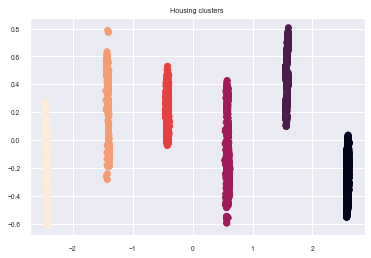

In [157]:
pca_data = PCA(n_components=2).fit(imputed_df)
pca_2d = pca_data.transform(imputed_df)
plt.scatter(pca_2d[:,0], pca_2d[:,1], c=labels)
plt.title('Housing clusters')
plt.show()


Plotting elbow method...
2 17404.24904989323
4 3497.8725374618552
6 1725.0885599494968


/home/drt15/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/drt15/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/drt15/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/drt15/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


8 1457.5435772508893
10 1264.725138808519


/home/drt15/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/drt15/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


12 1159.5434413925461


/home/drt15/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


14 1066.7857891351325


/home/drt15/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


16 944.3517141514853


/home/drt15/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


18 875.1925989149593


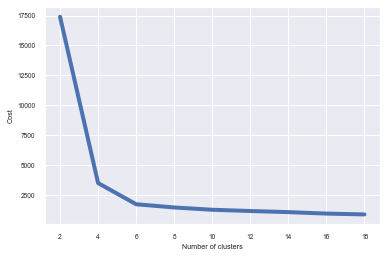

DONE


In [158]:
def elbow(data):
    print("\nPlotting elbow method...")
    sse = {}
    for k in range(2, 20, 2):
        kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
        print(k, kmeans.inertia_)
        sse[k] = kmeans.inertia_  
        # Inertia: Sum of distances of samples to their closest cluster center
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()), linewidth=4)
    plt.xlabel("Number of clusters")
    plt.ylabel("Cost")
    plt.show()
    print("DONE")
elbow(imputed_df)